## Learning Drag Coefficient vs Reynolds number for $0.01 < Re < 0.9$ for cylinder

In [1]:
# importing supporting libraries and using pytorch for deep neural network

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Define the exact solution - using log to counter multiscale nature of function
def exact_solution(x):
    gamma = 0.577215664901532
    return torch.log(8*pi/(x*(0.5-gamma+torch.log(8/x))))

Text(0, 0.5, 'u')

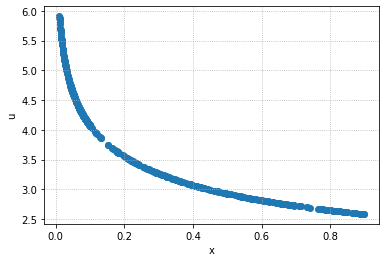

In [4]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"
# Random Seed for dataset generation
sampling_seed = 78
torch.manual_seed(sampling_seed)

# Number of training samples
n_samples = 250
n_sam = 250
# Noise level
sigma = 0.0
x1  = 0.09*torch.rand((n_samples, 1)) + 0.01
x2  = 0.8*torch.rand((n_sam, 1)) + 0.1
x = torch.cat((x1, x2))
y = exact_solution(x)*(1 + sigma*torch.randn(x.shape))


batch_size = n_samples + n_sam
training_set = DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=batch_size, shuffle=False)

plt.grid(True, which="both", ls=":")
plt.scatter(x,y)
plt.xlabel("x")
plt.ylabel("u")
#print(x)
#x.shape

# MODEL GENERATION

In [5]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [6]:
# Model definition

my_network = NeuralNet(input_dimension=x.shape[1], output_dimension=y.shape[1], n_hidden_layers=4, neurons=20)

In [7]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
# Model definition

# Predict network value of x
#print(my_network(x))

In [8]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [9]:
def fit(model, training_set, x, num_epochs, optimizer,p,  verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                #loss = torch.max(torch.abs((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))))
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history

In [10]:
n_epochs = 250
history = fit(my_network, training_set, x, n_epochs, optimizer_,p =2 , verbose=True )

################################  0  ################################
Loss:  14.918023109436035
################################  1  ################################
Loss:  14.278613090515137
################################  2  ################################
Loss:  11.334892272949219
################################  3  ################################
Loss:  8.788626670837402
################################  4  ################################
Loss:  7.263656139373779
################################  5  ################################
Loss:  6.136819362640381
################################  6  ################################
Loss:  5.203680515289307
################################  7  ################################
Loss:  4.41819429397583
################################  8  ################################
Loss:  3.7542824745178223
################################  9  ################################
Loss:  3.19067645072937
################################  10  ##########

/home/abhishek/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


Loss:  0.47803550958633423
################################  23  ################################
Loss:  0.4303542375564575
################################  24  ################################
Loss:  0.3901057243347168
################################  25  ################################
Loss:  0.35598862171173096
################################  26  ################################
Loss:  0.32692819833755493
################################  27  ################################
Loss:  0.30202457308769226
################################  28  ################################
Loss:  0.2805139422416687
################################  29  ################################
Loss:  0.26174429059028625
################################  30  ################################
Loss:  0.2451573759317398
################################  31  ################################
Loss:  0.23027603328227997
################################  32  ################################
Loss:  0.216691464185714

Loss:  0.0003872375236824155
################################  111  ################################
Loss:  0.0003569470136426389
################################  112  ################################
Loss:  0.00033187950612045825
################################  113  ################################
Loss:  0.0003103614435531199
################################  114  ################################
Loss:  0.00029261200688779354
################################  115  ################################
Loss:  0.00027709800633601844
################################  116  ################################
Loss:  0.000263998459558934
################################  117  ################################
Loss:  0.00025227523292414844
################################  118  ################################
Loss:  0.0002421535609755665
################################  119  ################################
Loss:  0.0002329123526578769
################################  120  ####################

################################  197  ################################
Loss:  7.895250746514648e-06
################################  198  ################################
Loss:  7.773592187731992e-06
################################  199  ################################
Loss:  7.667695172131062e-06
################################  200  ################################
Loss:  7.5739267231256235e-06
################################  201  ################################
Loss:  7.489252311643213e-06
################################  202  ################################
Loss:  7.412895229208516e-06
################################  203  ################################
Loss:  7.343923243752215e-06
################################  204  ################################
Loss:  7.281056241481565e-06
################################  205  ################################
Loss:  7.223885404528119e-06
################################  206  ################################
Loss:  7.172267487

In [11]:
n_samples1 = 10000
x1_test  = 0.09*torch.rand((n_samples1, 1)) + 0.01
x2_test  = 0.8*torch.rand((n_samples1, 1)) + 0.1
x_test = torch.cat((x1_test, x2_test))

In [12]:
x_test = x_test.reshape(-1,1)
y_test = exact_solution(x_test).reshape(-1,)

In [13]:
y_test_pred = my_network(x_test).reshape(-1,)

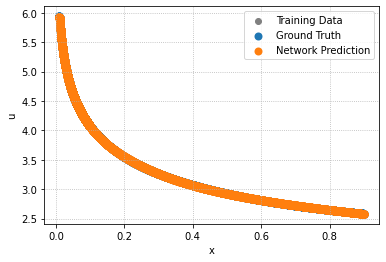

In [14]:
plt.grid(True, which="both", ls=":")
plt.scatter(x, y, label="Training Data", marker="o", color="grey")
plt.scatter(x_test, y_test, label="Ground Truth",lw=2)
plt.scatter(x_test, y_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [15]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((y_test_pred - y_test)**2)/torch.mean(y_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")
#relative_error_test = torch.max(torch.abs(y_test_pred  -y_test))/torch.max(torch.abs(y_test))
#print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  2.9079845376145386e-05 %


### Till now we have learned log of what was required. We take exponential of the data now to produce the actual relationship 

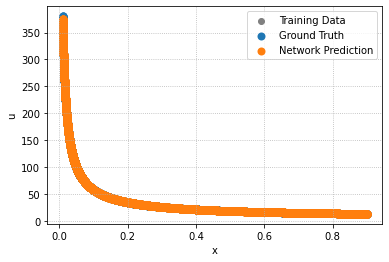

In [16]:
plt.grid(True, which="both", ls=":")
plt.scatter(x, np.exp(y), label="Training Data", marker="o", color="grey")
plt.scatter(x_test, np.exp(y_test), label="Ground Truth",lw=2)
plt.scatter(x_test, np.exp(y_test_pred.detach()), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((torch.exp(y_test_pred) - torch.exp(y_test))**2)/torch.mean(torch.exp(y_test)**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")


Relative Error Test:  0.0011577728400880005 %


In [18]:
print(y_test[-1])

tensor(3.7352)
